In [14]:
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
df = pd.read_csv("../data/train.csv")  
df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
df.shape, df.dtypes

((891, 12),
 PassengerId      int64
 Survived         int64
 Pclass           int64
 Name            object
 Sex             object
 Age            float64
 SibSp            int64
 Parch            int64
 Ticket          object
 Fare           float64
 Cabin           object
 Embarked        object
 dtype: object)

In [17]:
df.isna().sum().sort_values(ascending=False)


Cabin          687
PassengerId      0
Pclass           0
Survived         0
Name             0
Sex              0
SibSp            0
Age              0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

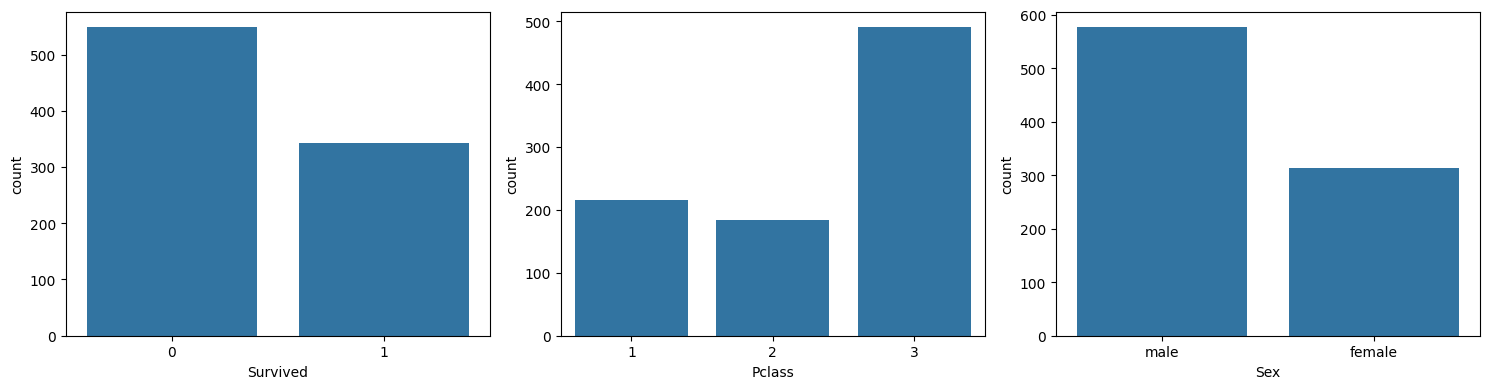

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(data=df, x='Survived', ax=axes[0])
sns.countplot(data=df, x='Pclass', ax=axes[1])
sns.countplot(data=df, x='Sex', ax=axes[2])
plt.tight_layout()
plt.show()

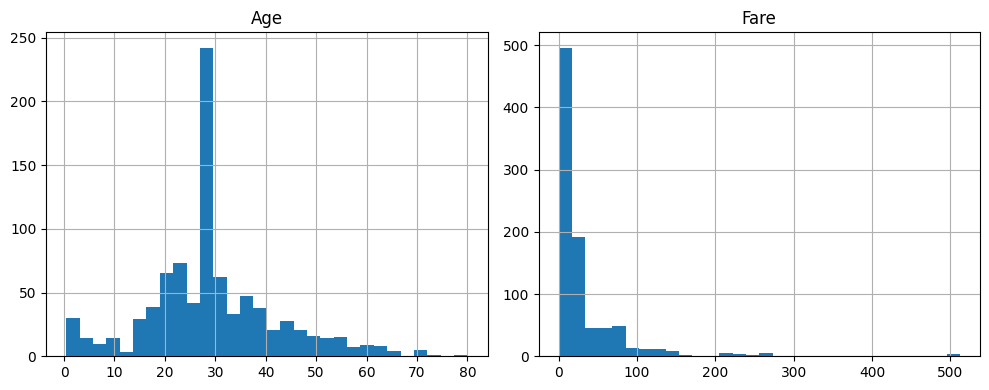

In [19]:
# Numeric distributions
num_cols = ['Age','Fare']
df[num_cols].hist(bins=30, figsize=(10,4))
plt.tight_layout()
plt.show()


In [20]:
FEATURES = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
TARGET = 'Survived'

data = df[FEATURES + [TARGET]].copy()
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [21]:
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data[TARGET], random_state=RANDOM_STATE)
os.makedirs('data', exist_ok=True)
test_df.to_csv('data/test.csv', index=False)  
len(train_df), len(test_df)


(712, 179)

In [22]:
from sklearn.impute import SimpleImputer

numeric_features = ['Age','SibSp','Parch','Fare']
categorical_features = ['Pclass','Sex','Embarked']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [23]:
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=RANDOM_STATE))
])

In [25]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

cv_logreg = cross_val_score(logreg_pipe, X_train, y_train, cv=5, scoring='accuracy')
cv_rf = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='accuracy')

print('LogReg CV Acc:', cv_logreg.mean().round(4), '+/-', cv_logreg.std().round(4))
print('RF     CV Acc:', cv_rf.mean().round(4), '+/-', cv_rf.std().round(4))

best_pipe = rf_pipe if cv_rf.mean() >= cv_logreg.mean() else logreg_pipe
best_name = 'RandomForest' if best_pipe is rf_pipe else 'LogisticRegression'
best_name

LogReg CV Acc: 0.7964 +/- 0.0177
RF     CV Acc: 0.7979 +/- 0.051


'RandomForest'

Test Accuracy: 0.8212

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



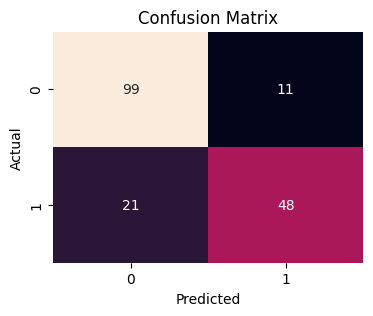

In [26]:
best_pipe.fit(X_train, y_train)

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

y_pred = best_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Test Accuracy:', round(acc, 4))

print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

In [27]:
joblib.dump(best_pipe, 'model.pkl')
print('Saved best model:', best_name, '-> model.pkl')

Saved best model: RandomForest -> model.pkl
